In [1]:
import numpy as np
import torch
import torchvision
import matplotlib.pyplot as plt

from time import time
from torchvision import transforms, datasets
from torch import nn, optim

In [2]:
import os
os.chdir("D:/ETU project/NN")

In [3]:
transform = transforms.Compose([transforms.Resize(112),
                                #transforms.CenterCrop(112),
                                transforms.ToTensor(),
                              #transforms.Grayscale()
                               ])
dataset = datasets.ImageFolder('Pistachio_Image_Dataset/Pistachio_Image_Dataset', transform=transform)

In [4]:
dataloader = torch.utils.data.DataLoader(dataset, batch_size=32, shuffle=True)
images, labels = next(iter(dataloader))
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 112, 112])
torch.Size([32])


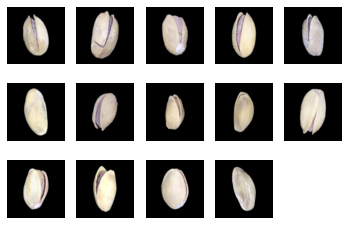

In [5]:
figure = plt.figure()
for index in range(1, 15):
    plt.subplot(3, 5, index)
    plt.axis('off')
    plt.imshow(images[index].permute(1,2,0).numpy().squeeze(), cmap='gray_r')

In [6]:
train_size = int(0.33 * len(dataloader.dataset))
test_size = len(dataloader.dataset) - train_size
train_dataset, test_dataset = torch.utils.data.random_split(dataloader.dataset, [train_size, test_size])

In [7]:
train_loader =  torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader =  torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)

In [8]:
images, labels = next(iter(train_loader))
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 112, 112])
torch.Size([32])


In [9]:
images, labels = next(iter(test_loader))
print(images.shape)
print(labels.shape)

torch.Size([32, 3, 112, 112])
torch.Size([32])


In [10]:
print(len(train_dataset))
print(len(test_dataset))

708
1440


In [11]:
labels = torch.zeros(2, dtype=torch.long)
for _, target in dataset:
    if target == 0:
        labels[0] += 1
    else:
        labels[1] += 1
labels

tensor([1232,  916])

In [12]:
labels = torch.zeros(2, dtype=torch.long)
for _, target in train_dataset:
    if target == 0:
        labels[0] += 1
    else:
        labels[1] += 1
labels

tensor([395, 313])

In [13]:
labels = torch.zeros(2, dtype=torch.long)
for _, target in test_dataset:
    if target == 0:
        labels[0] += 1
    else:
        labels[1] += 1
labels

tensor([837, 603])

In [14]:
input_size = images.shape[3]*images.shape[2]*images.shape[1]
hidden_sizes = [int(input_size/4),int(input_size/16), int(input_size/32)]
output_size = 1

In [15]:
model = nn.Sequential(nn.Linear(input_size, hidden_sizes[0]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[0], hidden_sizes[1]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[1], hidden_sizes[2]),
                      nn.ReLU(),
                      nn.Linear(hidden_sizes[2], output_size),
                      nn.Sigmoid()
                     )
print(model)

Sequential(
  (0): Linear(in_features=37632, out_features=9408, bias=True)
  (1): ReLU()
  (2): Linear(in_features=9408, out_features=2352, bias=True)
  (3): ReLU()
  (4): Linear(in_features=2352, out_features=1176, bias=True)
  (5): ReLU()
  (6): Linear(in_features=1176, out_features=1, bias=True)
  (7): Sigmoid()
)


In [16]:
loss_function = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [17]:
import torchmetrics

In [18]:
#loss_values = []
for epoch in range(0, 10): 
    print(f'Starting epoch {epoch+1}')
    metric = torchmetrics.Accuracy()
    current_loss = 0.0
    for images, labels in train_loader:
        images = images.view(images.shape[0], -1)
        labels = labels.unsqueeze(1).float()
        
        optimizer.zero_grad()
        output = model(images)
        
        loss = loss_function(output, labels)
        loss.backward()
        optimizer.step()
        
        current_loss += loss.item()
        metric.update(output, labels.long())
        
    else:
        print("Epoch {} - Training loss: {}, Acc: {}".format(epoch+1, current_loss/len(train_dataset), metric.compute()))
    #loss_values.append(current_loss / len(train_dataset))

print('Training process has finished.')

Starting epoch 1
Epoch 1 - Training loss: 0.01948530197480304, Acc: 0.659604549407959
Starting epoch 2
Epoch 2 - Training loss: 0.01534468432267507, Acc: 0.7895480394363403
Starting epoch 3
Epoch 3 - Training loss: 0.013510466590102783, Acc: 0.8192090392112732
Starting epoch 4
Epoch 4 - Training loss: 0.012413222889947352, Acc: 0.8290960192680359
Starting epoch 5
Epoch 5 - Training loss: 0.013562238380565481, Acc: 0.8064971566200256
Starting epoch 6
Epoch 6 - Training loss: 0.011791477816463527, Acc: 0.8305084705352783
Starting epoch 7
Epoch 7 - Training loss: 0.012185153251482268, Acc: 0.8389830589294434
Starting epoch 8
Epoch 8 - Training loss: 0.012894093148452414, Acc: 0.8347457647323608
Starting epoch 9
Epoch 9 - Training loss: 0.011442661306447229, Acc: 0.8446327447891235
Starting epoch 10
Epoch 10 - Training loss: 0.011591768828825762, Acc: 0.8502824902534485
Training process has finished.


In [19]:
#with torch.no_grad():
#    n_correct=0
#    n_samples=0
#    tp_0, fp_0, fn_0, tp_1, fp_1, fn_0 = 0,0,0,0,0,0
#    for images,labels in test_loader:
#        images=images.reshape(-1,images.shape[3]*images.shape[2]*images.shape[1])
#        output=model(images)
#        labels=labels
#        _,prediction=torch.max(output,1)
#        n_samples+=labels.shape[0]
#        n_correct+=(prediction==labels).sum().item()
#    accuracy=(n_correct/n_samples)*100

In [20]:
predicted = torch.Tensor()
target = torch.Tensor()

acc = torchmetrics.Accuracy()
roc = torchmetrics.AUROC()
conf = torchmetrics.ConfusionMatrix(num_classes=2)
f1_score = torchmetrics.F1Score()

C:\Users\admin\AppData\Local\Programs\Python\Python310\lib\site-packages\torchmetrics\utilities\prints.py:36: UserWarning: Metric `AUROC` will save all targets and predictions in buffer. For large datasets this may lead to large memory footprint.
  warnings.warn(*args, **kwargs)


In [21]:
with torch.no_grad():
    for images,labels in test_loader:
        images=images.reshape(-1,images.shape[3]*images.shape[2]*images.shape[1])
        output=model(images) 
        #_,prediction=torch.max(output,1)
        prediction = output.round()
        prediction = prediction.reshape(32,)
       # print(prediction.shape, predicted.shape)
        predicted = torch.cat((predicted, prediction))
        target = torch.cat((target, labels))

In [22]:
target = target.long()
predicted.shape, target.shape
predicted.unique()

tensor([0., 1.])

In [23]:
print(f1_score(predicted, target))
print(acc(predicted, target))
print(roc(predicted, target))
print(conf(predicted, target))

tensor(0.7909)
tensor(0.8271)
tensor(0.8207)
tensor([[720, 117],
        [132, 471]])


In [24]:
def view_classify(img, ps, label, probab):
    ps = ps.data.numpy().squeeze()
    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.permute(1,2,0).numpy().squeeze(), cmap='gray_r')
    ax1.axis('off')
    ax1.set_title("Predicted class = {}, true = {}".format(probab, label))
    ax2.barh(np.arange(2), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)
    plt.tight_layout()
def check(img, label):
    with torch.no_grad():
        ps = model(img)
        ps = torch.round(ps)
        probab = list(ps.numpy()[0])
        view_classify(img.view(images.shape[1], images.shape[2], images.shape[3]), ps, label, probab)



C:\Users\admin\AppData\Local\Temp\ipykernel_9640\3907735393.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)


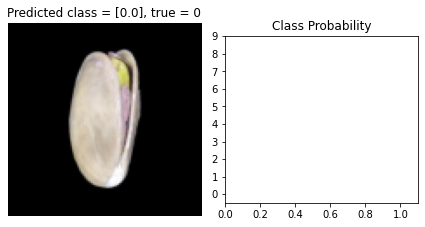

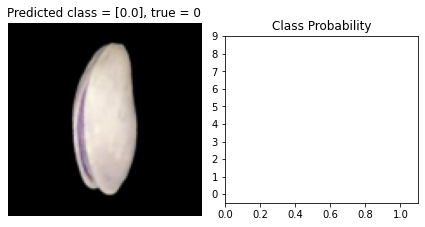

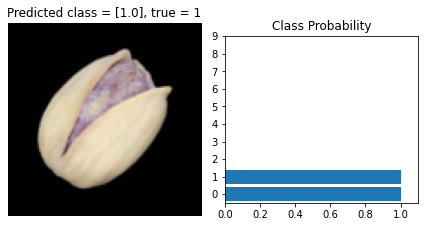

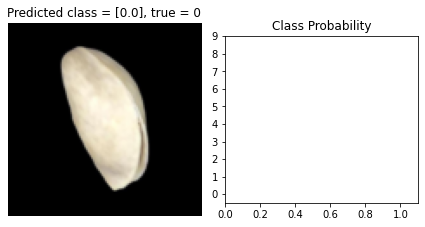

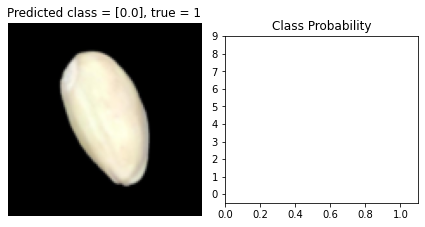

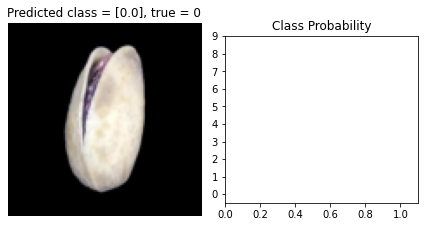

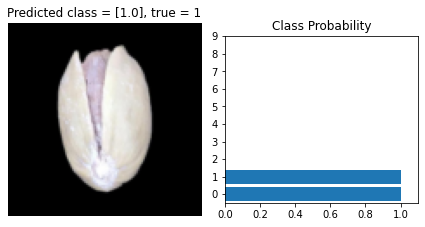

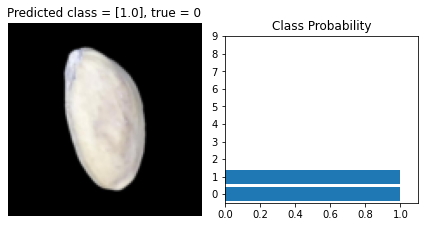

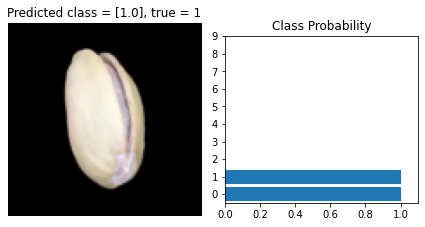

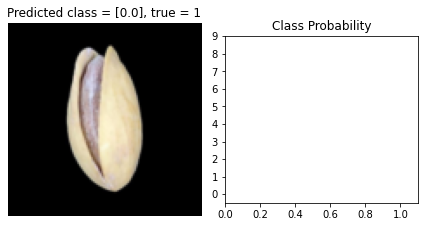

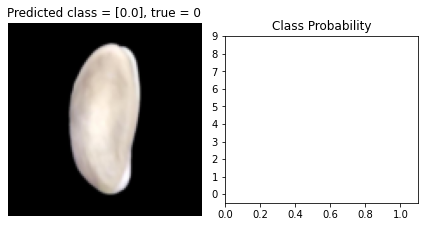

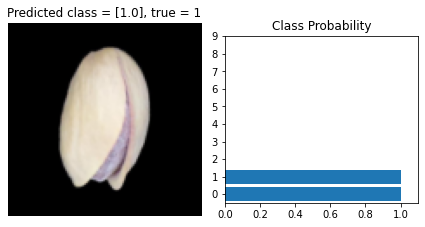

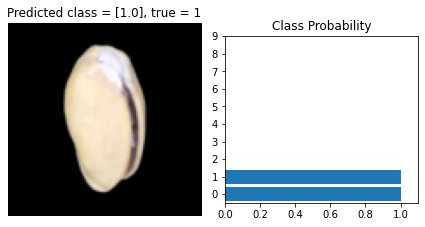

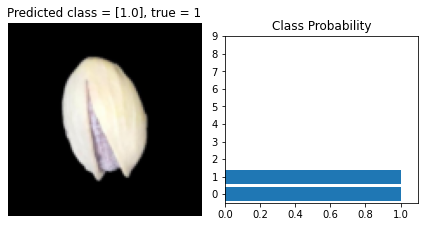

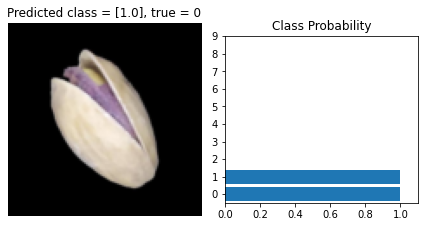

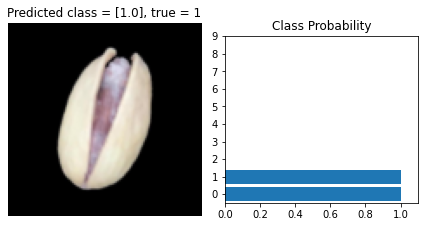

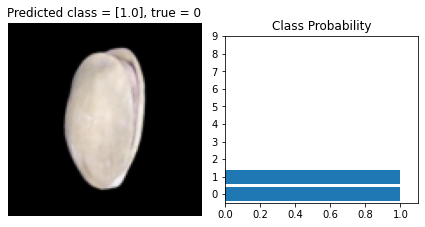

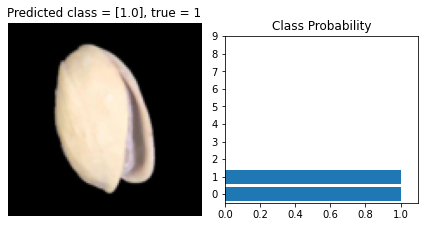

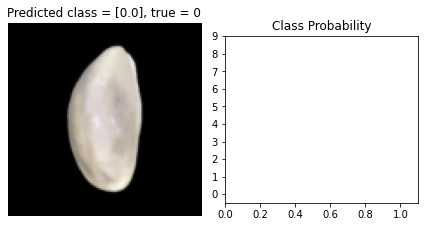

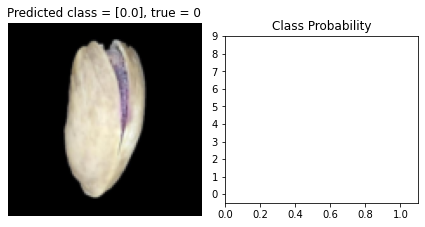

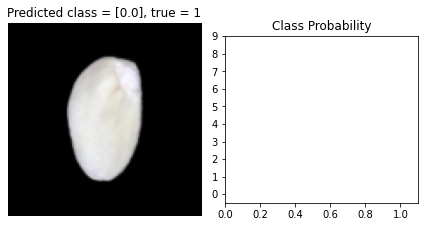

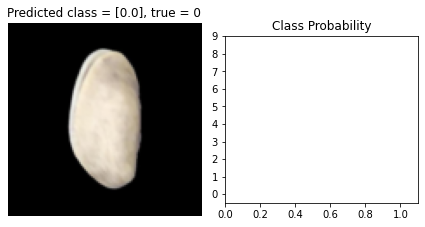

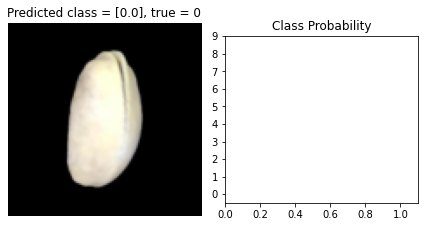

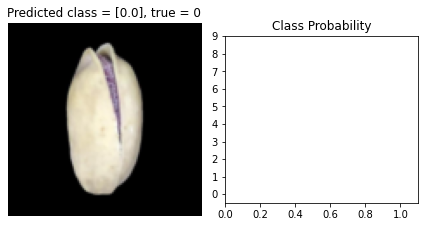

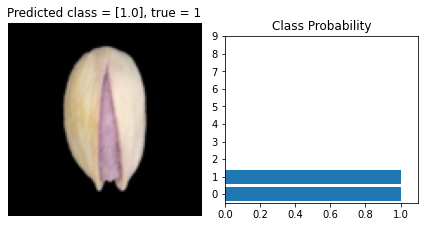

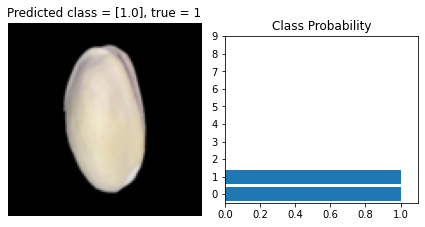

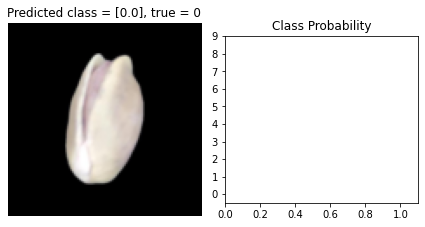

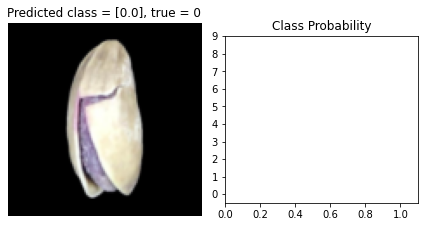

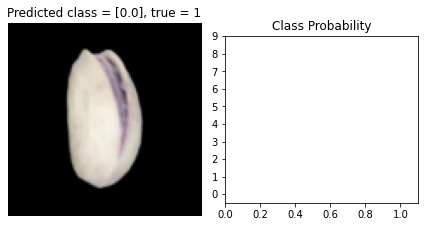

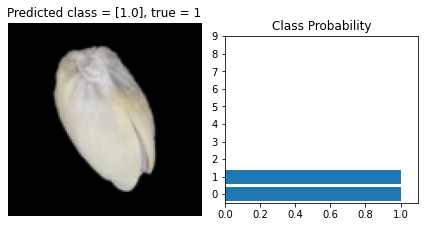

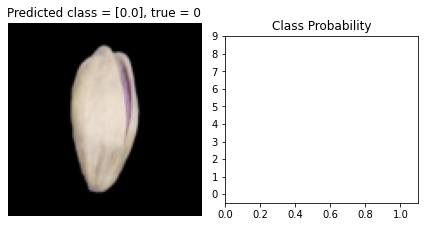

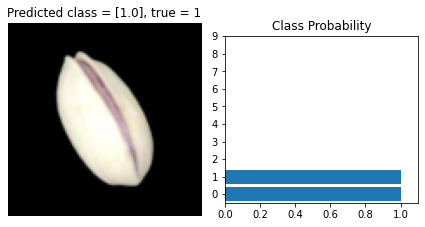

In [25]:
iterator = iter(test_loader)
images, labels = next(iterator)

for index in range(0, 32):
    check(images[index].view(-1, images.shape[3]*images.shape[2]*images.shape[1]), labels[index])

C:\Users\admin\AppData\Local\Temp\ipykernel_9640\3907735393.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)


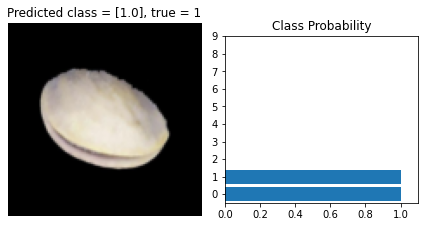

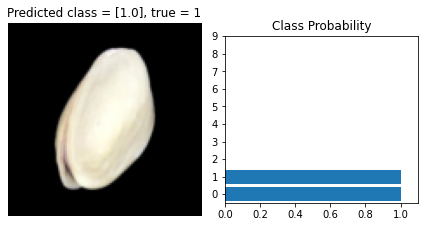

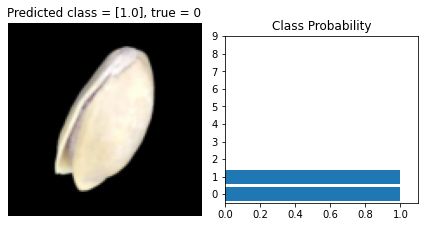

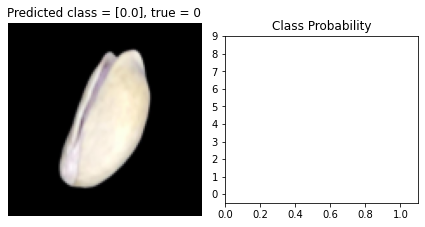

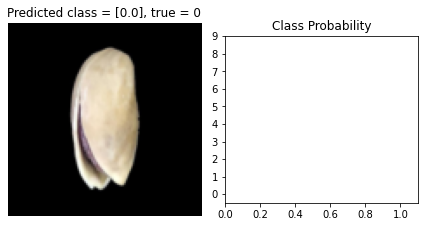

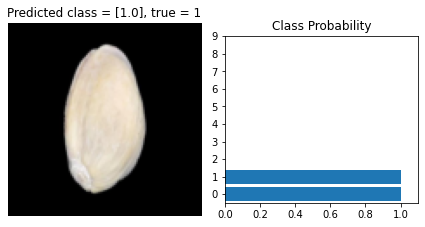

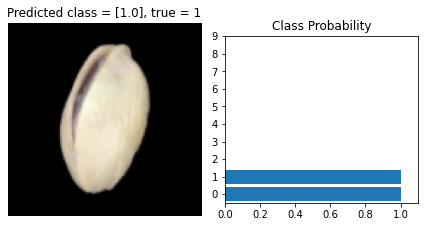

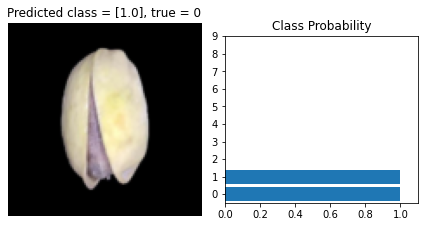

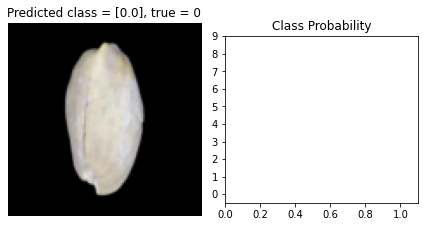

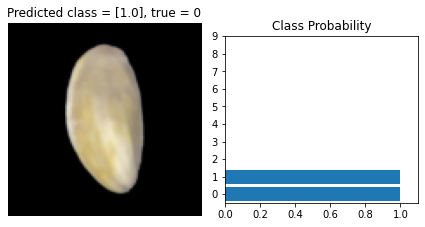

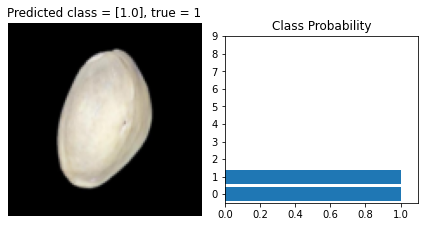

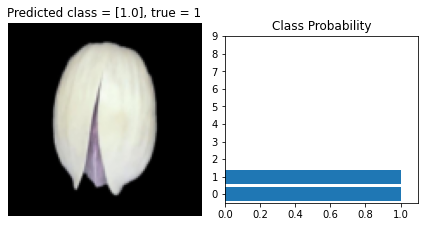

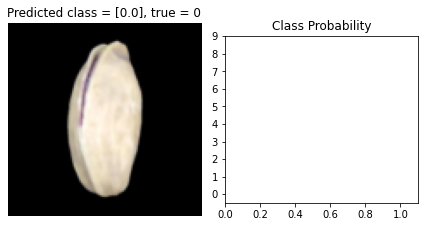

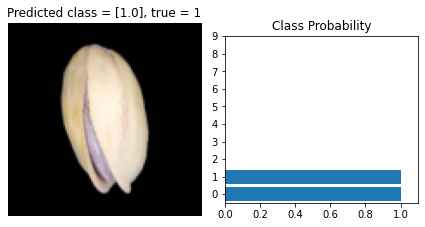

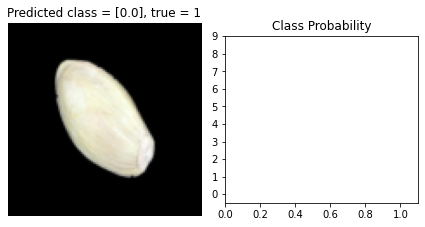

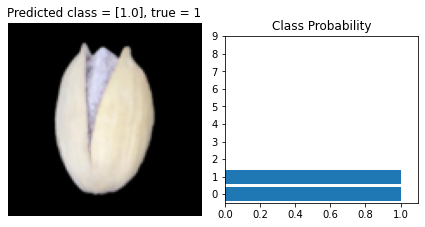

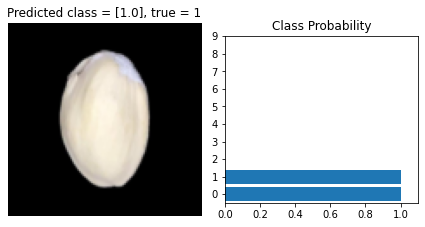

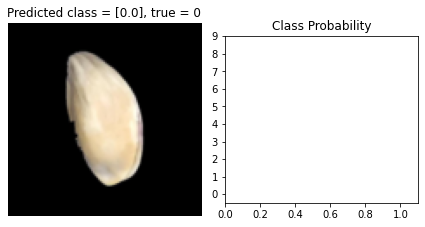

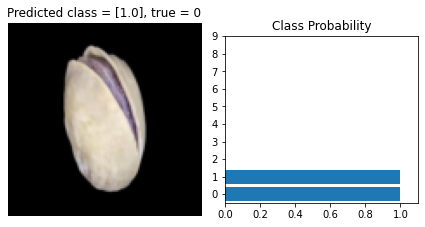

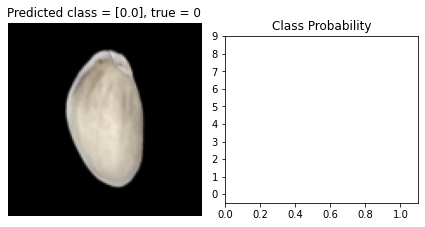

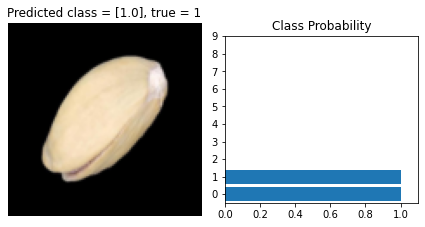

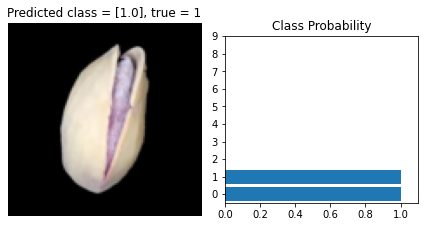

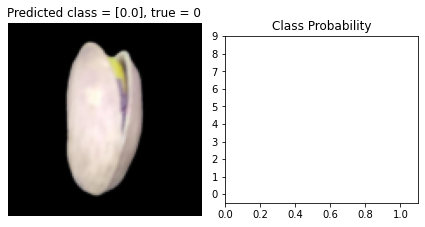

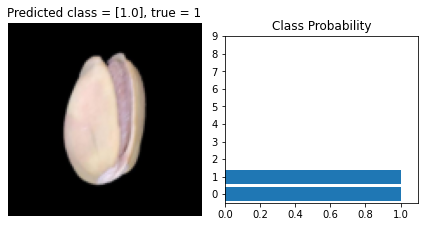

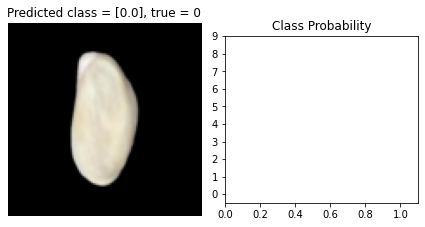

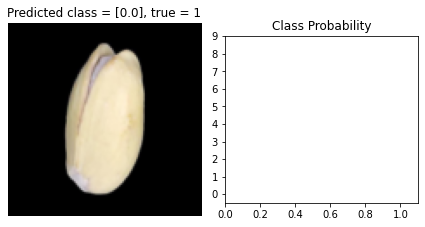

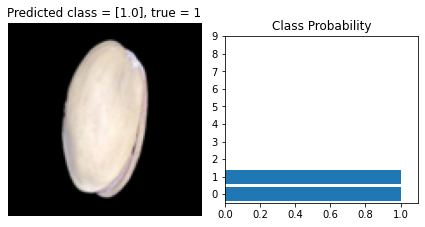

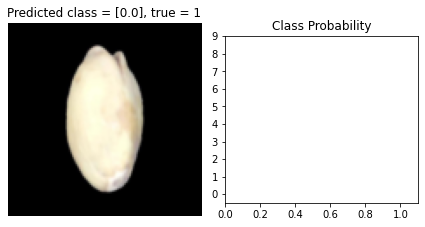

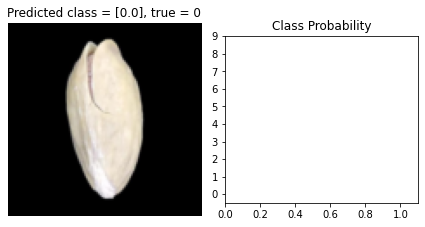

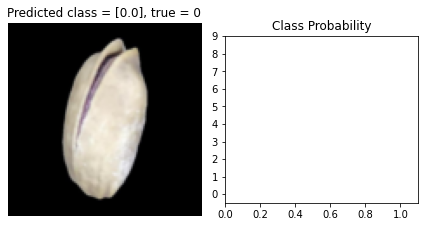

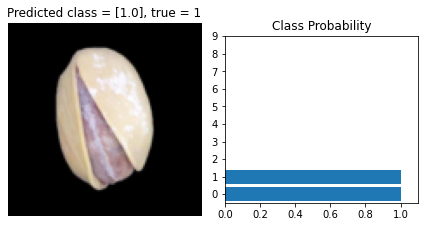

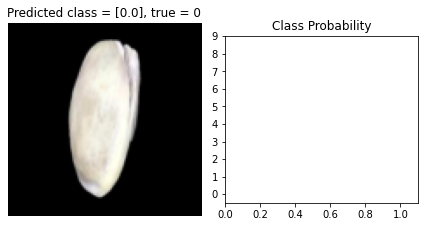

In [26]:
images, labels = next(iterator)

for index in range(0, 32):
    check(images[index].view(-1, images.shape[3]*images.shape[2]*images.shape[1]), labels[index])

C:\Users\admin\AppData\Local\Temp\ipykernel_9640\3907735393.py:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)


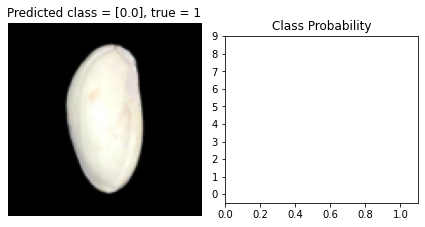

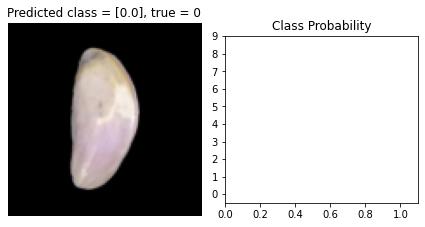

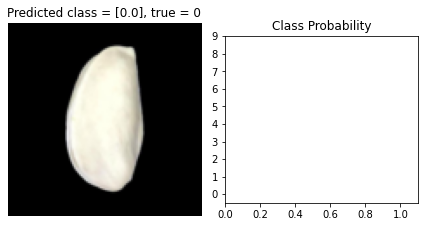

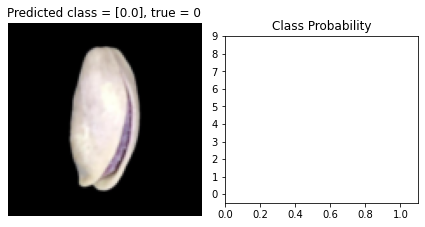

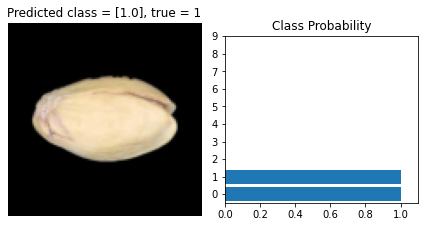

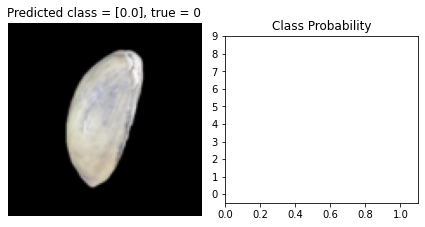

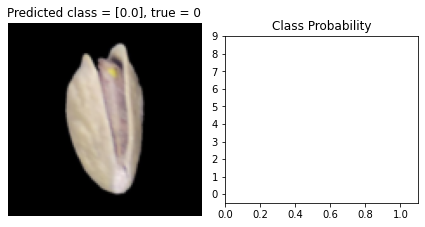

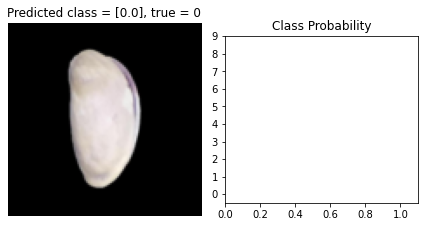

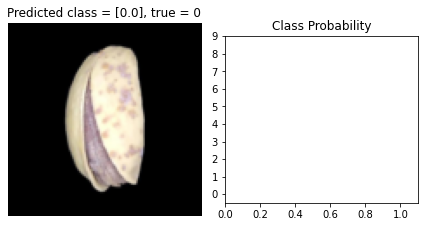

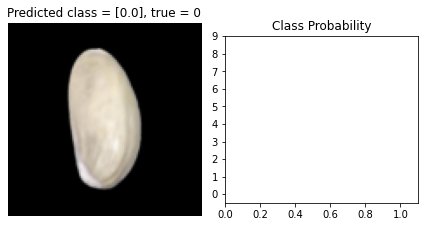

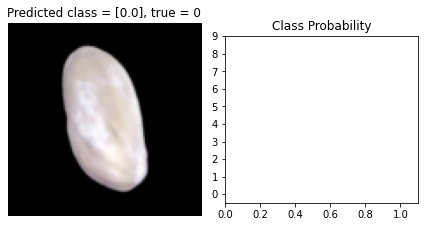

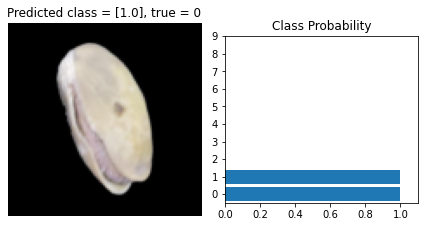

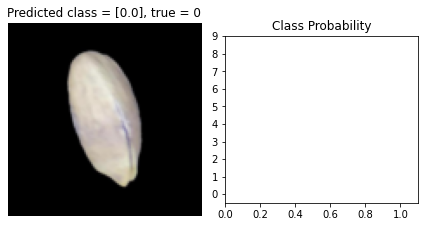

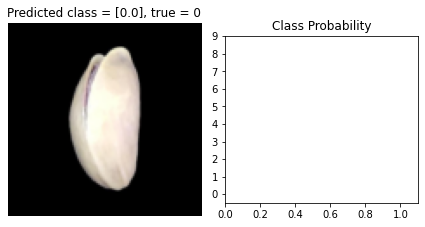

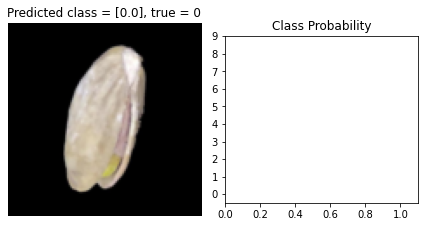

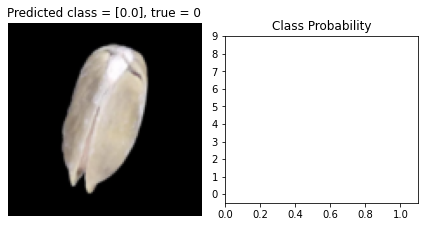

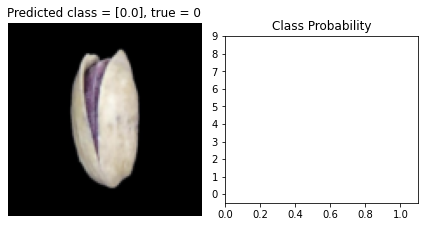

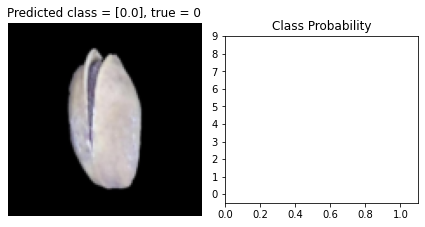

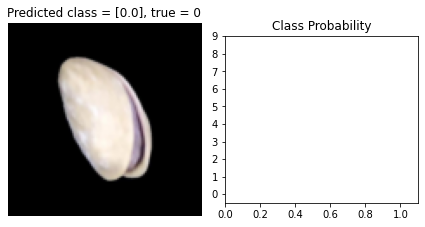

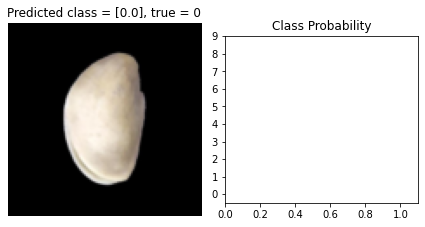

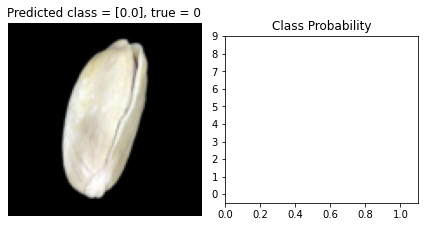

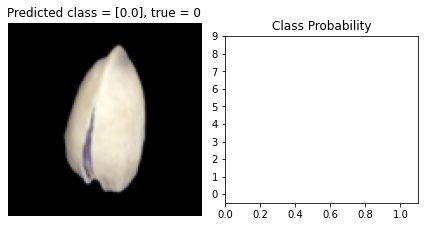

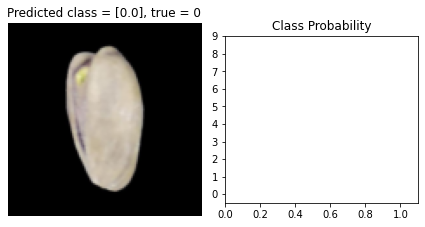

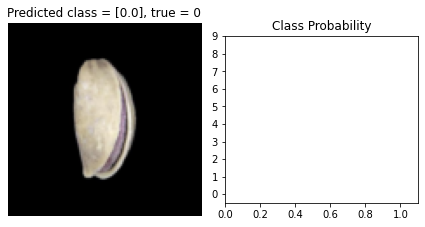

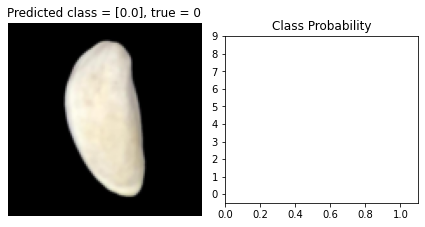

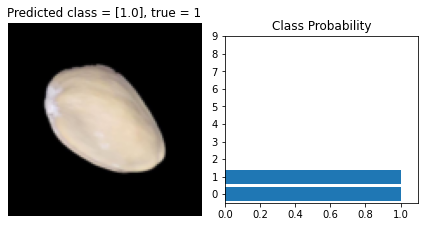

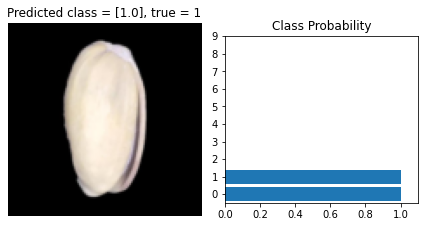

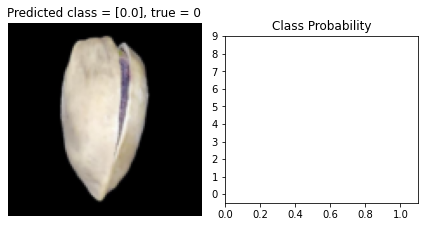

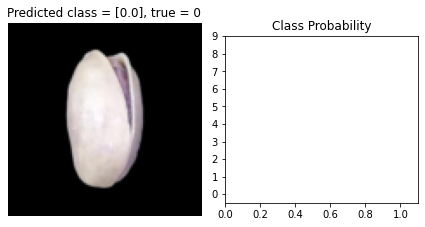

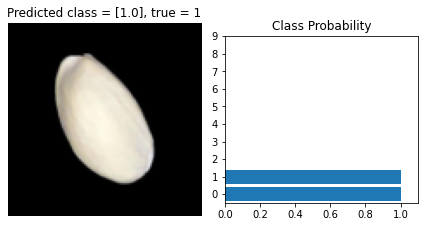

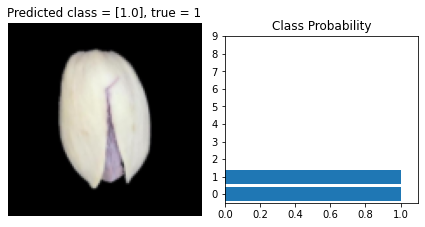

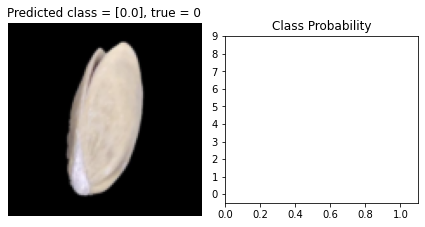

In [27]:
images, labels = next(iterator)

for index in range(0, 32):
    check(images[index].view(-1, images.shape[3]*images.shape[2]*images.shape[1]), labels[index])